In [ ]:
# Install the Kaggle API
!pip install kaggle

# Upload your Kaggle API token
from google.colab import files
files.upload()

# Move the API token to the appropriate directory
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/

# Set permissions for the token
!chmod 600 ~/.kaggle/kaggle.json

# Download the dataset
!kaggle datasets download -d akhatova/pcb-defects

# Unzip the dataset
!unzip -q pcb-defects.zip

# List the files in the dataset directory
!ls


Saving kaggle.json to kaggle.json
Dataset URL: https://www.kaggle.com/datasets/akhatova/pcb-defects
License(s): unknown
100% 1.88G/1.88G [00:25<00:00, 56.4MB/s]
100% 1.88G/1.88G [00:25<00:00, 77.9MB/s]
kaggle.json  PCB_DATASET  pcb-defects.zip  sample_data


In [ ]:
import os
import xml.etree.ElementTree as ET
import cv2
import shutil
import random

import numpy as np

#### Preprocessing

I will first resize the images to (640,640) so they are all the same and save them all in a folder

In [ ]:

#######resize images and join ########
# Define the target size
target_width =640
target_height = 640

# Path to the annotations folder
annotations_folder = "/content/PCB_DATASET/Annotations"

# Path to the images folder
images_folder = "/content/PCB_DATASET/images"

# Path to the output folder for resized images
resized_images_folder = "/content/PCB_DATASET/Resized_Images"
resize_ann_folder = "/content/PCB_DATASET/Resized_annot"

# Create the output folder if it doesn't exist
os.makedirs(resized_images_folder, exist_ok=True)
os.makedirs(resize_ann_folder, exist_ok=True)
# Function to resize and save an image
def resize_image(image_path, target_width, target_height):
    image = cv2.imread(image_path)
    resized_image = cv2.resize(image, (target_width, target_height))
    resized_image_path = os.path.join(resized_images_folder, os.path.basename(image_path))
    cv2.imwrite(resized_image_path, resized_image)
    return resized_image_path

# Function to resize bounding boxes
def resize_bounding_boxes(bounding_boxes, original_width, original_height, target_width, target_height):
    resized_boxes = []
    for bbox in bounding_boxes:
        x_min, y_min, x_max, y_max = bbox
        x_min_resized = int(x_min * target_width / original_width)
        y_min_resized = int(y_min * target_height / original_height)
        x_max_resized = int(x_max * target_width / original_width)
        y_max_resized = int(y_max * target_height / original_height)
        resized_boxes.append((x_min_resized, y_min_resized, x_max_resized, y_max_resized))
    return resized_boxes

# Process each class folder
for class_name in os.listdir(annotations_folder):
    class_annotations_folder = os.path.join(annotations_folder, class_name)
    class_images_folder = os.path.join(images_folder, class_name)

    if not os.path.isdir(class_annotations_folder) or not os.path.isdir(class_images_folder):
        continue

    # Process each annotation file in the class folder
    for filename in os.listdir(class_annotations_folder):
        if filename.endswith(".xml"):
            annotation_path = os.path.join(class_annotations_folder, filename)
            image_name = os.path.splitext(filename)[0] + ".jpg"
            image_path = os.path.join(class_images_folder, image_name)

            try:
                tree = ET.parse(annotation_path)
                root = tree.getroot()

                # Get image dimensions
                original_width = int(root.find("size/width").text)
                original_height = int(root.find("size/height").text)

                # Resize the image
                resized_image_path = resize_image(image_path, target_width, target_height)

                # Resize bounding boxes
                bounding_boxes = []
                for obj in root.findall("object"):
                    bbox = (
                        float(obj.find("bndbox/xmin").text),
                        float(obj.find("bndbox/ymin").text),
                        float(obj.find("bndbox/xmax").text),
                        float(obj.find("bndbox/ymax").text)
                    )
                    bounding_boxes.append(bbox)

                resized_boxes = resize_bounding_boxes(bounding_boxes, original_width, original_height, target_width, target_height)

                # Update XML annotation with resized bounding boxes
                for i, obj in enumerate(root.findall("object")):
                    obj.find("bndbox/xmin").text = str(resized_boxes[i][0])
                    obj.find("bndbox/ymin").text = str(resized_boxes[i][1])
                    obj.find("bndbox/xmax").text = str(resized_boxes[i][2])
                    obj.find("bndbox/ymax").text = str(resized_boxes[i][3])

                # Save the updated annotation
                resized_annotation_path = os.path.join(resize_ann_folder, filename)
                tree.write(resized_annotation_path)

            except Exception as e:
                print(f"Error processing file {filename}: {e}")


change the annotation to yolo format

In [ ]:

#######change to yolo format #########
# Define the class mapping (modify as needed)
class_mapping = {
    "missing_hole": 0,
    "mouse_bite": 1,
    "open_circuit": 2,
    "short": 3,
    "spur": 4,
    "spurious_copper": 5
}

# Path to the annotations folder
annotations_folder = "/content/PCB_DATASET/Annotations"

# Path to the YOLO label folder
yolo_label_folder = "/content/PCB_DATASET/yolo_annotations"

# Create the YOLO label folder if it doesn't exist
os.makedirs(yolo_label_folder, exist_ok=True)

# Process each annotation file
for root_dir, dirs, files in os.walk(annotations_folder):
    for filename in files:
        if filename.endswith(".xml"):
            annotation_path = os.path.join(root_dir, filename)
            try:
                tree = ET.parse(annotation_path)
                root = tree.getroot()

                # Get image dimensions
                width = int(root.find("size/width").text)
                height = int(root.find("size/height").text)

                # Create the YOLO label file
                yolo_label_path = os.path.join(yolo_label_folder, os.path.splitext(filename)[0] + ".txt")
                with open(yolo_label_path, "w") as f:
                    for obj in root.findall("object"):
                        class_name = obj.find("name").text
                        class_id = class_mapping.get(class_name)
                        if class_id is not None:
                            bbox = obj.find("bndbox")
                            xmin = float(bbox.find("xmin").text)
                            ymin = float(bbox.find("ymin").text)
                            xmax = float(bbox.find("xmax").text)
                            ymax = float(bbox.find("ymax").text)

                            # Calculate normalized coordinates
                            x_center = (xmin + xmax) / (2 * width)
                            y_center = (ymin + ymax) / (2 * height)
                            bbox_width = (xmax - xmin) / width
                            bbox_height = (ymax - ymin) / height

                            # Write to the YOLO label file
                            f.write(f"{class_id} {x_center:.6f} {y_center:.6f} {bbox_width:.6f} {bbox_height:.6f}\n")
            except Exception as e:
                print(f"Error processing file {filename}: {e}")

print("Annotations converted to YOLO format.")


Annotations converted to YOLO format.


split the data into test train and val ready for yolo model where each folder has image folder and label folder

In [ ]:

######split into test train and val ######
def split_dataset(images_dir, annotations_dir, train_dir, val_dir, test_dir, split_ratio=(0.8, 0.1, 0.1)):
    # Create train, validation, and test directories if they don't exist
    for directory in [train_dir, val_dir, test_dir]:
        os.makedirs(os.path.join(directory, "images"), exist_ok=True)
        os.makedirs(os.path.join(directory, "labels"), exist_ok=True)

    # Get list of image filenames (excluding directories)
    image_filenames = [f for f in os.listdir(images_dir) if os.path.isfile(os.path.join(images_dir, f))]
    random.shuffle(image_filenames)

    # Split filenames into train, validation, and test sets
    num_images = len(image_filenames)
    num_train = int(split_ratio[0] * num_images)
    num_val = int(split_ratio[1] * num_images)
    num_test = num_images - num_train - num_val

    train_filenames = image_filenames[:num_train]
    val_filenames = image_filenames[num_train:num_train + num_val]
    test_filenames = image_filenames[num_train + num_val:]

    # Move images and labels to train directory
    move_images_and_labels(train_filenames, images_dir, annotations_dir, train_dir)

    # Move images and labels to validation directory
    move_images_and_labels(val_filenames, images_dir, annotations_dir, val_dir)

    # Move images and labels to test directory
    move_images_and_labels(test_filenames, images_dir, annotations_dir, test_dir)

def move_images_and_labels(filenames, images_dir, annotations_dir, destination_dir):
    for filename in filenames:
        # Move image
        image_src = os.path.join(images_dir, filename)
        image_dest = os.path.join(destination_dir, "images", filename)
        shutil.copy(image_src, image_dest)

        # Find corresponding label filename
        label_filename = os.path.splitext(filename)[0] + ".txt"
        if label_filename not in os.listdir(annotations_dir):
            print(f"Warning: No corresponding label found for '{filename}'")
            continue

        # Move label
        label_src = os.path.join(annotations_dir, label_filename)
        label_dest = os.path.join(destination_dir, "labels", label_filename)
        shutil.copy(label_src, label_dest)
images_dir = "/content/PCB_DATASET/Resized_Images"
annotations_dir = "/content/PCB_DATASET/yolo_annotations"
train_dir = "/content/PCB_DATASET/train"
val_dir = "/content/PCB_DATASET/validation"
test_dir = "/content/PCB_DATASET/test"

# Define the split ratio (train:val:test)
split_ratio = (0.8, 0.1, 0.1)

# Split the dataset
split_dataset(images_dir, annotations_dir, train_dir, val_dir, test_dir, split_ratio)


#### Performing Augmentation

In [ ]:
!pip install albumentations


we will have to convert the annotations to a format ready for augmentation for the albumentations library
This will only be perfromed for train images

In [ ]:
import os
####### convert to format ready for augmentation for the train labelsss #########
class_mapping = {
    "missing_hole": 0,
    "mouse_bite": 1,
    "open_circuit": 2,
    "short": 3,
    "spur": 4,
    "spurious_copper": 5
}

def convert_yolo_format_to_list(yolo_txt_file):
    bboxes = []
    with open(yolo_txt_file, 'r') as f:
        lines = f.readlines()
        for line in lines:
            class_index, x_center, y_center, width, height = map(float, line.strip().split())
            class_name = list(class_mapping.keys())[int(class_index)]
            bbox = [x_center, y_center, width, height, class_name]
            bboxes.append(bbox)
    return bboxes

def convert_yolo_format_in_folder(folder_path):
    all_annotations = []
    file_names = sorted(os.listdir(folder_path))  # Sort the list of file names
    for file_name in file_names:
        if file_name.endswith('.txt'):
            yolo_txt_file = os.path.join(folder_path, file_name)
            bboxes = convert_yolo_format_to_list(yolo_txt_file)
            all_annotations.append(bboxes)
    return all_annotations

# Example usage
folder_path = "/content/PCB_DATASET/train/labels"
annotations_list = convert_yolo_format_in_folder(folder_path)
print(annotations_list)


[[[0.822182, 0.820618, 0.023401, 0.034678, 'missing_hole'], [0.542518, 0.230139, 0.021753, 0.039092, 'missing_hole'], [0.580587, 0.519546, 0.023401, 0.037831, 'missing_hole']], [[0.862558, 0.167087, 0.021753, 0.041614, 'missing_hole'], [0.786421, 0.524275, 0.013184, 0.035939, 'missing_hole'], [0.505109, 0.522699, 0.017469, 0.034048, 'missing_hole']], [[0.881839, 0.320933, 0.01615, 0.027743, 'missing_hole'], [0.450725, 0.487074, 0.016809, 0.029634, 'missing_hole'], [0.694957, 0.378941, 0.017469, 0.02396, 'missing_hole']], [[0.542518, 0.158575, 0.017798, 0.033417, 'missing_hole'], [0.11915, 0.494325, 0.01615, 0.037831, 'missing_hole'], [0.081411, 0.654477, 0.019776, 0.03657, 'missing_hole']], [[0.486157, 0.322194, 0.019117, 0.039092, 'missing_hole'], [0.446935, 0.779319, 0.019776, 0.041614, 'missing_hole'], [0.693804, 0.523329, 0.023072, 0.037831, 'missing_hole']], [[0.918589, 0.462484, 0.019776, 0.042245, 'missing_hole'], [0.879532, 0.85971, 0.020765, 0.034678, 'missing_hole'], [0.16826

apply the augementation to train folder and save the images with labels transformed to yolo format

In [ ]:

import albumentations as A
from google.colab.patches import cv2_imshow

# Define class mapping dictionary
class_mapping = {
    "missing_hole": 0,
    "mouse_bite": 1,
    "open_circuit": 2,
    "short": 3,
    "spur": 4,
    "spurious_copper": 5
}

# Function to apply augmentations to images and their corresponding bounding boxes
def apply_augmentation(images_folder, annotations_list, output_image_folder, output_annotation_folder):
    # Define augmentation pipeline
    transform = A.Compose([
        A.HorizontalFlip(p=0.5),
        A.Rotate(limit=30, p=0.5),
        A.RandomBrightnessContrast(p=0.2),
        A.Resize(640, 640),
    ], bbox_params=A.BboxParams(format='yolo'))  # Change format if needed

    # Iterate over each image and its corresponding annotations

    for idx, (image_file, annotations) in enumerate(zip(sorted(os.listdir(images_folder)), annotations_list)):
        if image_file.endswith('.jpg'):  # Assuming images are in JPG format

            image_path = os.path.join(images_folder, image_file)

            # Read image
            image = cv2.imread(image_path)
            image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

            # Apply augmentation to image and bounding boxes
            augmented = transform(image=image, bboxes=annotations)
            transformed_image = augmented['image']
            transformed_annotations = augmented['bboxes']

            # Save augmented image
            output_image_path = os.path.join(output_image_folder, f"augmented_image_{idx}.jpg")
            cv2.imwrite(output_image_path, transformed_image)

            # Save augmented bounding box annotations in YOLO format
            output_annotation_file = f"augmented_image_{idx}.txt"
            save_annotations(output_annotation_folder, output_annotation_file, transformed_annotations)


# Function to save augmented bounding box annotations in YOLO format
def save_annotations(output_folder, annotation_file, annotations):
    output_file = os.path.join(output_folder, annotation_file)

    with open(output_file, 'w') as f:
        for annotation in annotations:
            # Unpack annotation
            x_center, y_center, width, height, class_name = annotation

            # Get class ID from class mapping
            class_id = class_mapping[class_name]

            # Write annotation in YOLO format
            f.write(f"{class_id} {x_center} {y_center} {width} {height}\n")

# Example usage
images_folder = "/content/PCB_DATASET/train/images"
annotations_list = annotations_list  # Assuming you have the list of annotations
output_image_folder = "/content/PCB_DATASET/train/images"
output_annotation_folder = "/content/PCB_DATASET/train/labels"

apply_augmentation(images_folder, annotations_list, output_image_folder, output_annotation_folder)


Visualize an augmented image with box

[[0.3055369999999999, 0.668663, 0.021094000000000057, 0.03341700000000003, '0'], [0.17666400000000004, 0.71343, 0.018456999999999946, 0.03341700000000003, '0'], [0.305867, 0.342371, 0.01911700000000005, 0.03656999999999999, '0']]


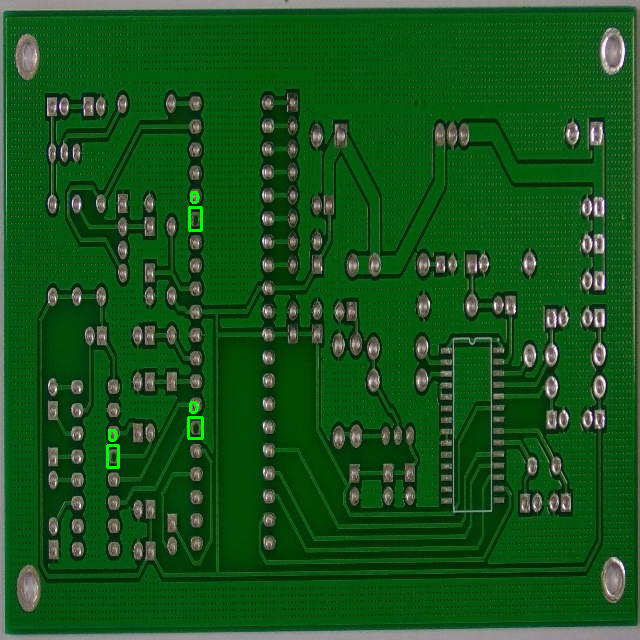

In [ ]:


def read_annotations(annotation_path):
    with open(annotation_path, 'r') as f:
        lines = f.readlines()

    annotations = []
    for line in lines:

        values = line.strip().split()
        class_name = values[0]
        x_center, y_center, width, height = map(float, values[1:])
        annotations.append([x_center, y_center, width, height, class_name])
    print(annotations)
    return annotations

def visualize(image_folder, annotation_folder, image_file):
    image_path = os.path.join(image_folder, image_file)
    annotation_path = os.path.join(annotation_folder, image_file.replace('.jpg', '.txt'))

    # Read the image
    image = cv2.imread(image_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

    # Read annotations
    annotations = read_annotations(annotation_path)

    # Draw bounding boxes on the image
    for annotation in annotations:
        x_center, y_center, width, height, class_name = annotation

        # Convert bounding box coordinates to pixel values
        x_min = int((x_center - width / 2) * image.shape[1])
        y_min = int((y_center - height / 2) * image.shape[0])
        x_max = int((x_center + width / 2) * image.shape[1])
        y_max = int((y_center + height / 2) * image.shape[0])

        # Draw bounding box on the image
        cv2.rectangle(image, (x_min, y_min), (x_max, y_max), (0, 255, 0), 2)
        cv2.putText(image, class_name, (x_min, y_min - 5), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 255, 0), 2)

    # Display the image with bounding boxes
    cv2_imshow(image)
    cv2.waitKey(0)
    cv2.destroyAllWindows()

# Example usage
image_folder = "/content/PCB_DATASET/train/images"
annotation_folder = "/content/PCB_DATASET/train/labels"

# Replace "image_file" with the name of the image file you want to visualize
image_file = "augmented_image_10.jpg"

visualize(image_folder, annotation_folder, image_file)


#### Yolo Model

In [ ]:
%pip install ultralytics
import ultralytics


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 755.1/755.1 kB 5.2 MB/s eta 0:00:00
  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (23.7 MB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (823 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (14.1 MB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl (731.7 MB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl (410.6 MB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl (121.6 MB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.whl (56.5 MB)
  Using cached nvidia_cusolver_cu12-11.4.5.107-py3-none-manylinux1_x86_64.whl (124.2 MB)
  Using cached nvidia_cusparse_cu12-12.1.0.106-py3-none-manylinux1_x86_64.whl (196.0 MB)
  Using cached nvidia_nccl_cu12-2.19.3-py3-none-manylinux1_x86_64.whl (166.0 MB)
  Using cached nvidia_nvtx_cu12-12.1.105-py3-none-many

we will use yolov8 for object detection in the medium size and we perfrom training

In [ ]:
from ultralytics import YOLO

# Load a model
model = YOLO('yolov8n.yaml')  # build a new model from scratch
model = YOLO('yolov8n.pt')  # load a pretrained model (recommended for training)

# Use the model
results = model.train(data='/content/data.yaml', epochs=50)  # train the model



100%|██████████| 6.23M/6.23M [00:00<00:00, 85.6MB/s]


Ultralytics YOLOv8.2.7 🚀 Python-3.10.12 torch-2.2.1+cu121 CUDA:0 (Tesla T4, 15102MiB)
engine/trainer: task=detect, mode=train, model=yolov8n.pt, data=/content/data.yaml, epochs=50, time=None, patience=100, batch=16, imgsz=640, save=True, save_period=-1, cache=False, device=None, workers=8, project=None, name=train, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, embed=None, show=False, save_frames=False, save_txt=False, save_conf=False, save_crop=False, show_labels=True, show_conf=True, show_boxes=Tru

100%|██████████| 755k/755k [00:00<00:00, 17.1MB/s]


Overriding model.yaml nc=80 with nc=6

                   from  n    params  module                                       arguments                     
  0                  -1  1       464  ultralytics.nn.modules.conv.Conv             [3, 16, 3, 2]                 
  1                  -1  1      4672  ultralytics.nn.modules.conv.Conv             [16, 32, 3, 2]                
  2                  -1  1      7360  ultralytics.nn.modules.block.C2f             [32, 32, 1, True]             
  3                  -1  1     18560  ultralytics.nn.modules.conv.Conv             [32, 64, 3, 2]                
  4                  -1  2     49664  ultralytics.nn.modules.block.C2f             [64, 64, 2, True]             
  5                  -1  1     73984  ultralytics.nn.modules.conv.Conv             [64, 128, 3, 2]               
  6                  -1  2    197632  ultralytics.nn.modules.block.C2f             [128, 128, 2, True]           
  7                  -1  1    295424  ultralytics

train: Scanning /content/PCB_DATASET/train/labels... 1108 images, 0 backgrounds, 0 corrupt: 100%|██████████| 1108/1108 [00:02<00:00, 420.91it/s]

train: New cache created: /content/PCB_DATASET/train/labels.cache


albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01), CLAHE(p=0.01, clip_limit=(1, 4.0), tile_grid_size=(8, 8))


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
val: Scanning /content/PCB_DATASET/validation/labels... 69 images, 0 backgrounds, 0 corrupt: 100%|██████████| 69/69 [00:00<00:00, 289.99it/s]

val: New cache created: /content/PCB_DATASET/validation/labels.cache


Plotting labels to runs/detect/train/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.001, momentum=0.9) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.0005), 63 bias(decay=0.0)
TensorBoard: model graph visualization added ✅
Image sizes 640 train, 640 val
Using 2 dataloader workers
Logging results to runs/detect/train
Starting training for 50 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/50      2.66G      3.494      6.627      1.683         29        640: 100%|██████████| 70/70 [00:33<00:00,  2.06it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:02<00:00,  1.35it/s]

                   all         69        277          0          0          0          0



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/50      2.35G      2.674      4.402      1.214         41        640: 100%|██████████| 70/70 [00:29<00:00,  2.40it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  4.37it/s]

                   all         69        277      0.296      0.244      0.185     0.0781



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/50      2.36G      2.459      3.431      1.146         23        640: 100%|██████████| 70/70 [00:29<00:00,  2.41it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  4.85it/s]

                   all         69        277      0.425      0.395      0.367      0.155



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/50      2.32G      2.291       2.91      1.116         32        640: 100%|██████████| 70/70 [00:28<00:00,  2.44it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  5.05it/s]

                   all         69        277      0.509      0.487      0.423      0.176



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/50      2.34G      2.208      2.527      1.081         34        640: 100%|██████████| 70/70 [00:28<00:00,  2.42it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  5.77it/s]

                   all         69        277      0.664       0.42      0.478      0.187



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/50      2.33G      2.109      2.207      1.064         35        640: 100%|██████████| 70/70 [00:27<00:00,  2.51it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  5.53it/s]

                   all         69        277      0.633      0.561      0.583      0.268



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       7/50      2.36G      2.074      2.044      1.044         17        640: 100%|██████████| 70/70 [00:30<00:00,  2.32it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  5.08it/s]

                   all         69        277      0.679      0.553      0.581      0.227



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       8/50      2.33G      2.051      1.905      1.046         18        640: 100%|██████████| 70/70 [00:28<00:00,  2.48it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  5.56it/s]

                   all         69        277      0.742      0.653      0.692      0.294



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       9/50      2.34G      1.964      1.782      1.026         39        640: 100%|██████████| 70/70 [00:29<00:00,  2.39it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  3.29it/s]

                   all         69        277      0.711      0.713      0.736      0.329



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      10/50      2.33G      1.939      1.613      1.007         19        640: 100%|██████████| 70/70 [00:28<00:00,  2.45it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  5.70it/s]

                   all         69        277      0.723      0.665      0.709      0.305



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      11/50      2.35G      1.968      1.639      1.016         31        640: 100%|██████████| 70/70 [00:29<00:00,  2.38it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.08it/s]

                   all         69        277      0.735      0.651      0.722      0.328



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      12/50      2.32G      1.894       1.53      1.006         18        640: 100%|██████████| 70/70 [00:28<00:00,  2.49it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  5.60it/s]

                   all         69        277      0.848      0.645      0.749      0.363



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      13/50      2.34G      1.863      1.433      1.003         12        640: 100%|██████████| 70/70 [00:28<00:00,  2.45it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.68it/s]

                   all         69        277      0.761      0.677      0.749       0.37



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      14/50      2.33G       1.86      1.429     0.9994         24        640: 100%|██████████| 70/70 [00:28<00:00,  2.44it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  5.72it/s]

                   all         69        277      0.868      0.701       0.81      0.396



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      15/50      2.21G      1.831      1.371     0.9915         14        640: 100%|██████████| 70/70 [00:28<00:00,  2.46it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.69it/s]

                   all         69        277      0.797      0.739      0.805      0.373



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      16/50      2.33G      1.832      1.376     0.9872         23        640: 100%|██████████| 70/70 [00:27<00:00,  2.53it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  5.74it/s]

                   all         69        277      0.835      0.714       0.83      0.394



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      17/50      2.33G        1.8      1.302      0.972         33        640: 100%|██████████| 70/70 [00:28<00:00,  2.43it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  5.33it/s]

                   all         69        277      0.836      0.721      0.806      0.339



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      18/50      2.33G      1.784      1.279     0.9784         25        640: 100%|██████████| 70/70 [00:27<00:00,  2.51it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  5.64it/s]

                   all         69        277      0.864      0.688      0.805       0.38



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      19/50      2.33G       1.79      1.284     0.9636         19        640: 100%|██████████| 70/70 [00:28<00:00,  2.47it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  5.07it/s]

                   all         69        277      0.877       0.75      0.861      0.432



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      20/50      2.35G      1.725       1.19     0.9652         20        640: 100%|██████████| 70/70 [00:29<00:00,  2.40it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  5.79it/s]

                   all         69        277      0.886      0.784      0.851      0.411



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      21/50      2.33G      1.716       1.16     0.9574         19        640: 100%|██████████| 70/70 [00:29<00:00,  2.38it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  5.27it/s]

                   all         69        277      0.853      0.785      0.872      0.436



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      22/50      2.33G      1.717      1.148     0.9555         13        640: 100%|██████████| 70/70 [00:28<00:00,  2.43it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  5.55it/s]

                   all         69        277      0.907      0.812      0.895      0.434



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      23/50      2.36G      1.724      1.145     0.9564         33        640: 100%|██████████| 70/70 [00:28<00:00,  2.49it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  5.93it/s]

                   all         69        277      0.859      0.828        0.9      0.447



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      24/50      2.32G      1.712      1.144      0.958         17        640: 100%|██████████| 70/70 [00:29<00:00,  2.37it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.94it/s]

                   all         69        277      0.847      0.791      0.868      0.433



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      25/50      2.34G       1.69       1.13     0.9546         21        640: 100%|██████████| 70/70 [00:27<00:00,  2.55it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  5.70it/s]

                   all         69        277      0.869      0.803      0.867      0.416



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      26/50      2.32G      1.666      1.087     0.9384         21        640: 100%|██████████| 70/70 [00:27<00:00,  2.50it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  5.60it/s]

                   all         69        277      0.927      0.793       0.89      0.443



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      27/50      2.36G      1.643      1.045     0.9439         18        640: 100%|██████████| 70/70 [00:28<00:00,  2.43it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  5.02it/s]

                   all         69        277      0.874      0.816      0.885      0.441



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      28/50      2.35G       1.64      1.065     0.9401         36        640: 100%|██████████| 70/70 [00:28<00:00,  2.44it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  5.71it/s]

                   all         69        277      0.924      0.809      0.896      0.462



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      29/50      2.32G      1.627      1.023     0.9383          8        640: 100%|██████████| 70/70 [00:28<00:00,  2.42it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  5.19it/s]

                   all         69        277      0.899      0.826      0.892      0.441



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      30/50      2.32G      1.632      1.037       0.94         39        640: 100%|██████████| 70/70 [00:28<00:00,  2.46it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  5.49it/s]

                   all         69        277      0.925      0.842      0.909      0.472



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      31/50      2.21G       1.61      1.014     0.9315         19        640: 100%|██████████| 70/70 [00:29<00:00,  2.35it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.59it/s]

                   all         69        277      0.911      0.819      0.898       0.47



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      32/50      2.35G      1.628      1.004     0.9345         11        640: 100%|██████████| 70/70 [00:27<00:00,  2.55it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  5.52it/s]

                   all         69        277       0.91      0.819      0.905      0.462



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      33/50      2.34G      1.624     0.9838     0.9259         17        640: 100%|██████████| 70/70 [00:28<00:00,  2.48it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  5.90it/s]

                   all         69        277      0.913      0.846      0.911      0.462



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      34/50      2.33G      1.571     0.9651     0.9197         25        640: 100%|██████████| 70/70 [00:29<00:00,  2.39it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  5.18it/s]

                   all         69        277      0.919      0.856      0.905      0.464



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      35/50      2.36G      1.551      0.944     0.9276         19        640: 100%|██████████| 70/70 [00:28<00:00,  2.49it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  5.52it/s]

                   all         69        277      0.921       0.85      0.917      0.476



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      36/50      2.35G      1.554     0.9386     0.9216         15        640: 100%|██████████| 70/70 [00:28<00:00,  2.44it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  5.83it/s]

                   all         69        277       0.93      0.845      0.911      0.466



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      37/50      2.33G      1.542     0.9247     0.9167         19        640: 100%|██████████| 70/70 [00:28<00:00,  2.48it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  4.98it/s]

                   all         69        277      0.921      0.852      0.919       0.48



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      38/50      2.32G      1.535     0.9297     0.9171         22        640: 100%|██████████| 70/70 [00:29<00:00,  2.37it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  5.68it/s]

                   all         69        277      0.952      0.851      0.917      0.486



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      39/50      2.34G      1.521     0.9019     0.9151         23        640: 100%|██████████| 70/70 [00:27<00:00,  2.50it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  5.01it/s]

                   all         69        277      0.931      0.853       0.92      0.497



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      40/50      2.21G      1.508     0.9003     0.9106         38        640: 100%|██████████| 70/70 [00:28<00:00,  2.49it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  1.91it/s]

                   all         69        277      0.912      0.879      0.922      0.493


Closing dataloader mosaic
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01), CLAHE(p=0.01, clip_limit=(1, 4.0), tile_grid_size=(8, 8))


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      41/50      2.44G      1.476     0.8269      0.934         16        640: 100%|██████████| 70/70 [00:29<00:00,  2.36it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  5.10it/s]

                   all         69        277      0.918      0.868      0.918      0.485



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      42/50       2.3G      1.436     0.8089     0.9211         15        640: 100%|██████████| 70/70 [00:26<00:00,  2.69it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  5.72it/s]

                   all         69        277      0.904      0.874      0.923      0.465



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      43/50      2.32G      1.402     0.7862     0.9195         20        640: 100%|██████████| 70/70 [00:27<00:00,  2.59it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  3.10it/s]

                   all         69        277      0.923      0.887      0.922      0.475



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      44/50       2.3G      1.389     0.7608     0.9158         16        640: 100%|██████████| 70/70 [00:25<00:00,  2.71it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  4.98it/s]

                   all         69        277      0.935       0.85       0.92      0.477



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      45/50       2.3G       1.38     0.7545      0.909         19        640: 100%|██████████| 70/70 [00:27<00:00,  2.59it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  5.97it/s]

                   all         69        277      0.938      0.894      0.932      0.474



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      46/50       2.3G      1.396     0.7737     0.9099         16        640: 100%|██████████| 70/70 [00:26<00:00,  2.66it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  4.61it/s]

                   all         69        277      0.927      0.883      0.935      0.477



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      47/50       2.3G       1.35       0.74     0.9002         16        640: 100%|██████████| 70/70 [00:26<00:00,  2.69it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  5.24it/s]

                   all         69        277       0.94      0.844      0.924      0.481



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      48/50       2.3G      1.356     0.7298     0.9023         17        640: 100%|██████████| 70/70 [00:26<00:00,  2.67it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  5.55it/s]

                   all         69        277      0.945      0.874      0.935      0.485



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      49/50       2.3G      1.322     0.7206     0.8983         14        640: 100%|██████████| 70/70 [00:27<00:00,  2.58it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  6.01it/s]

                   all         69        277      0.952      0.888      0.941      0.488



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      50/50       2.3G      1.325     0.7214     0.8996         14        640: 100%|██████████| 70/70 [00:27<00:00,  2.58it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  5.12it/s]

                   all         69        277       0.95      0.888       0.94      0.488



50 epochs completed in 0.420 hours.
Optimizer stripped from runs/detect/train/weights/last.pt, 6.3MB
Optimizer stripped from runs/detect/train/weights/best.pt, 6.3MB

Validating runs/detect/train/weights/best.pt...
Ultralytics YOLOv8.2.7 🚀 Python-3.10.12 torch-2.2.1+cu121 CUDA:0 (Tesla T4, 15102MiB)
Model summary (fused): 168 layers, 3006818 parameters, 0 gradients, 8.1 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.49it/s]


                   all         69        277      0.931      0.852       0.92      0.497
          missing_hole         69         45       0.94      0.978      0.973      0.581
            mouse_bite         69         69      0.982      0.776      0.918      0.472
          open_circuit         69         42      0.923       0.81      0.924      0.432
                 short         69         42       0.94      0.929      0.925      0.537
                  spur         69         32      0.888       0.75      0.824      0.442
       spurious_copper         69         47      0.915      0.872      0.954      0.516
Speed: 0.2ms preprocess, 3.3ms inference, 0.0ms loss, 3.1ms postprocess per image
Results saved to runs/detect/train


evaluate on the validation folder

In [ ]:
results = model.val()  # evaluate model performance on the validation set

Ultralytics YOLOv8.2.7 🚀 Python-3.10.12 torch-2.2.1+cu121 CUDA:0 (Tesla T4, 15102MiB)
Model summary (fused): 168 layers, 3006818 parameters, 0 gradients, 8.1 GFLOPs


val: Scanning /content/PCB_DATASET/validation/labels.cache... 69 images, 0 backgrounds, 0 corrupt: 100%|██████████| 69/69 [00:00<?, ?it/s]
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:06<00:00,  1.21s/it]


                   all         69        277      0.931      0.852      0.923      0.499
          missing_hole         69         45       0.94      0.978      0.973      0.582
            mouse_bite         69         69      0.982      0.772      0.918      0.481
          open_circuit         69         42      0.928       0.81      0.926      0.434
                 short         69         42       0.94      0.929      0.946      0.547
                  spur         69         32      0.895       0.75      0.823      0.438
       spurious_copper         69         47      0.901      0.872      0.952      0.514
Speed: 0.4ms preprocess, 38.3ms inference, 0.0ms loss, 6.8ms postprocess per image
Results saved to runs/detect/train2


perfrom prediciton on the test folder

In [ ]:
model = YOLO('/content/runs/detect/train/weights/best.pt')
# Perform object detection on images in a test folder
results = model('/content/PCB_DATASET/test/images',save=True)


image 1/70 /content/PCB_DATASET/test/images/01_missing_hole_07.jpg: 640x640 3 missing_holes, 32.4ms
image 2/70 /content/PCB_DATASET/test/images/01_mouse_bite_02.jpg: 640x640 1 open_circuit, 38.5ms
image 3/70 /content/PCB_DATASET/test/images/01_mouse_bite_14.jpg: 640x640 1 mouse_bite, 15.1ms
image 4/70 /content/PCB_DATASET/test/images/01_open_circuit_04.jpg: 640x640 2 open_circuits, 15.0ms
image 5/70 /content/PCB_DATASET/test/images/01_open_circuit_10.jpg: 640x640 1 open_circuit, 15.5ms
image 6/70 /content/PCB_DATASET/test/images/01_short_10.jpg: 640x640 3 shorts, 14.1ms
image 7/70 /content/PCB_DATASET/test/images/01_short_15.jpg: 640x640 2 shorts, 16.7ms
image 8/70 /content/PCB_DATASET/test/images/01_spur_05.jpg: 640x640 1 spur, 27.4ms
image 9/70 /content/PCB_DATASET/test/images/01_spur_09.jpg: 640x640 (no detections), 14.9ms
image 10/70 /content/PCB_DATASET/test/images/01_spurious_copper_09.jpg: 640x640 3 spurious_coppers, 14.7ms
image 11/70 /content/PCB_DATASET/test/images/04_missin